In [1]:
import csv
import nltk
import operator
import functools
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.tokenize import word_tokenize
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
 
# Load library
from nltk.corpus import stopwords
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm

In [2]:
nltk.download('wordnet') # Required for Lemmatization
nltk.download('punkt') # Required for Tokenization
nltk.download('stopwords') # Required for removing stopwords

from nltk.stem import WordNetLemmatizer 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehro\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
df = pd.read_csv('TRAIN_SMS.csv', encoding='latin-1')
df.head(n=10)

FileNotFoundError: [Errno 2] No such file or directory: 'TRAIN_SMS.csv'

## Feature Engineering and Data Analysis

In [6]:
def remove_punc_lemm_list(s):
    # Replace punctutations with space
    # This will also replace any punctuations from between words.
    # For ex: R.No. -> r no
    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    s = s.translate(translator) 
    lemmatizer = WordNetLemmatizer() 
    tokens = list(map(lambda s: lemmatizer.lemmatize(s), word_tokenize(s)))
    return tokens

def remove_punc_lemm(s):
    tokens = remove_punc_lemm_list(s)
    return " ".join(tokens)

def remove_punc_stop_words_lemm(s):
    tokens = remove_punc_lemm_list(s)
    # Load stop words
    stop_words = stopwords.words('english')
    s = ' '.join([i for i in tokens if i not in stop_words])
    return s
  
def remove_stop_words(s):
    # This can also be done directly in CountVectorizer but done here to do further analysis.
    tokens = s.split()
    stop_words = stopwords.words('english')
    s = ' '.join([i for i in tokens if i not in stop_words])
    return s

print(remove_punc_lemm("namit is rocks"))
print(remove_punc_stop_words_lemm("namit is rocks"))

# Count number of punctuations in a sentence
punctuation_count = lambda s: len(list(filter(functools.partial(operator.contains, string.punctuation), s)))

namit is rock
namit rock


In [ ]:
def prepare_data_for_train(df):
  df['message'] = df.apply(lambda row: row.Message.lower(), axis = 1)  #Lower case
  df['punc_count'] = df.apply(lambda row: punctuation_count(row.message), axis = 1)  #Punctuation counts
  df['length'] = df.apply(lambda row: len(row.message), axis = 1)  #Length of sentence
  df['punc_removed'] = df.apply(lambda row: remove_punc_lemm(row.message), axis=1)  #Lemmatized Sentence without punctuations
  df['stop_removed'] = df.apply(lambda row: remove_stop_words(row.punc_removed), axis=1)  #Lemmatized Sentence without punc/stop_words
  return df

df = prepare_data_for_train(df)
# This is removed as Spell correction was taking too much time.
# df['mistakes_removed'] = df.apply(lambda row: spell_corrected(row.punc_removed), axis=1) 

Let us first check the overall class distribution.

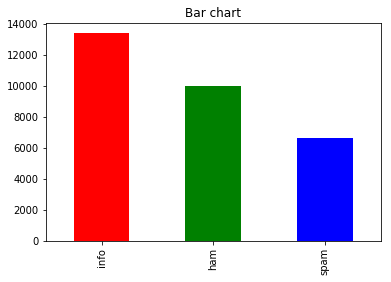

info    13375
ham     10000
spam     6625
Name: Label, dtype: int64


In [ ]:
count_class = pd.value_counts(df["Label"])
count_class.plot(kind='bar', color= ["red", "green", "blue"])
plt.title('Bar chart')
plt.show()
print(df['Label'].value_counts())

Let us look at overall distribution of length of sentences and may be figure out if this can be used as one of the distinguishing features for predicting the classes.

Text(0, 0.5, 'Frequency')

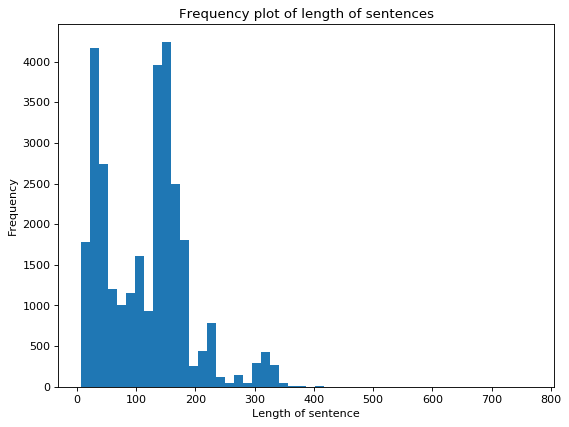

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
df['length'].plot(bins=50,kind='hist')
# Plot formatting
plt.title('Frequency plot of length of sentences')
plt.xlabel('Length of sentence')
plt.ylabel('Frequency')

It looks like most of the sentence lengths are approximately between 0-80 and 130-190. This can be attributed to the character limit of a SMS. If a SMS is just above the limit, people try to shorten/remove some words to put it in a single SMS.
Let us also look at the statistics of `length`.

In [ ]:
df['length'].describe()

count    30000.000000
mean       116.538833
std         73.012630
min          7.000000
25%         45.000000
50%        132.000000
75%        158.000000
max        768.000000
Name: length, dtype: float64

The max length is 768 and min is 7. Let us quickly see what kind of labels we have there.

In [ ]:
print('Distribution of sentences with length more than or equal to 400 is:')
print(df[df['length']>=400]['Label'].value_counts())

print("\nLet us look at the SPAM messages:\n")
print('\n'.join(list(df[df['length']>=400]['Message'])))

Distribution of sentences with length more than or equal to 400 is:
spam    19
Name: Label, dtype: int64

Let us look at the SPAM messages:

Hurry up!!! Last few days to register for Royal Mysuru Marathon. It is not only a Running Event encouraging Health &amp; Fitness, but also a Charity Event to raise funds to support the under privileged communities through participating Civil Society Organizations (CSOs/NGOs) in and around Mysuru.&#10;&#10;To register please visit the link - http://bit.ly/2imMTGp.&#10;&#10;Happy Running,&#10;Royal Mysuru Marathon
ashokadv76 has left a message for your ad "Blue 2006 Maruti Suz...":"Hi &#10;pls send photos". To reply back click http://www.quikr.com/app/mobchat/?iqchd=YXJ1bndpenotZ21haWwuY29tLWVAY2hhdC5rdWlrci5jb20=&amp;jhqchd=YXNob2thZHY3Ni1nbWFpbC5jb20tZUBjaGF0Lmt1aWtyLmNvbQ==&amp;xdzchqd=MjM4MDQwNjkx&amp;utm_source=chat&amp;utm_medium=sms&amp;utm_campaign=reply_chat' toa="null" sc_toa="null" service_center="9219853982" read="1" status="-1" locked="

1.   Looks like many of these contains URLs. That can be one of the factors to decide on SPAM.
2.   Also many of these contains many punctuations. This factor can also be explored to test our hypothesis that SPAMs are likely to contain more punctuations.



In [ ]:
print('Distribution of sentences with length less than or equal to 30 is:')
print(df[df['length']<=30]['Label'].value_counts())

print("\nLet us look at the messages:\n")
print('\n'.join(list(df[df['length']<=30]['Message'])))

Distribution of sentences with length less than or equal to 30 is:
ham    4124
Name: Label, dtype: int64

Let us look at the messages:

Tommy is my brother
I will indeed! What time?
lets meet 29th after diwali
meeting is @ sharp 4am
drop off mary to john's home
wish nishu happy birthday
hey lets hv lunch together.
pay mortgage tomorrow
Ha ha..thnx buddy
birthday party on wed
Evening@five past 5
I guess I'll go too then
In meeting. Urgent?
will let u know in a minute
meet from 12pm till evening
Sounds good, how about 6pm?
def. Where and when
Next wed..Sorry :P
okk done..c u there at 6pm
bring files to office
Tom is coming during January
Enquire in Bangalore
he will come at 6pm
Lets plan a trip to goa.
lets meet 2 days after 6
meet mary before office
pick up tuxedos Saturday
Fashion Week at at 11
meet john on every single day
go to the movie on Sunday
I didn't get IT return money
will meet for 48 hours
I'll call you later.
yeah what time is it again?
lets meet after a month
greet mary an

All of these messages are HAM. Points to note:


1.   Many of these contains time, date, etc.
2.   All of them are very short and contains mostly stop words (Most commonly used words)



Let us also plot the `Length` distribution class-wise to give us better insight.

In [ ]:
# We will make a method as this will also be used later for exploring other features as well.
def plot_dist_by(feature, norm_hist=True, kde=False):
  figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
  sns.distplot(df[df['Label']=='ham'][feature],norm_hist=norm_hist, kde=kde, label='Ham')
  sns.distplot(df[df['Label']=='spam'][feature],norm_hist=norm_hist, kde=kde, label='Spam')
  sns.distplot(df[df['Label']=='info'][feature],norm_hist=norm_hist, kde=kde, label='Info')
  
  # Plot formatting
  plt.legend(title = 'Label')
  plt.title(f'Normalized Density Plot of {feature} for different classes')
  plt.xlabel(f'{feature}')
  plt.ylabel('Density')

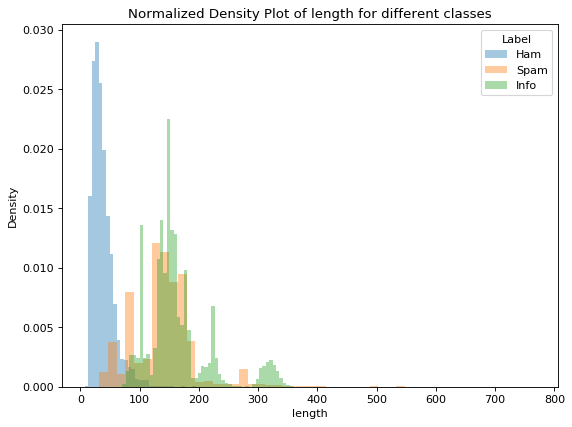

In [ ]:
plot_dist_by('length')

Text(0, 0.5, 'Length')

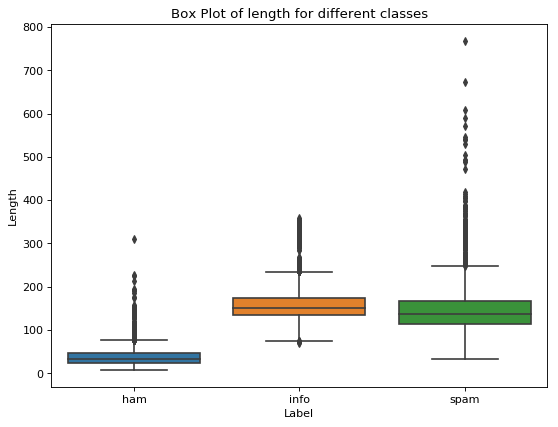

In [ ]:
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.boxplot(x="Label", y='length', data=df)
plt.title(f'Box Plot of length for different classes')
plt.xlabel('Label')
plt.ylabel('Length')

From the above two plots, we can clearly distuinguish HAM from the rest.

Let us also look at `punctuation_counts` in a sentence as we observed above that it can be explored to differentiate SPAMs.

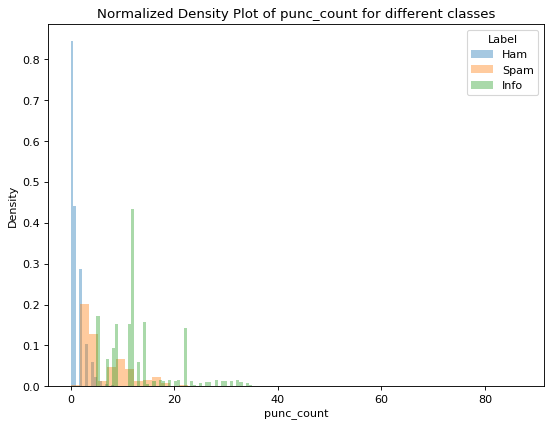

In [ ]:
plot_dist_by('punc_count')

Looks like our hypothesis was not correct. Instead, INFO contains more punctuations than SPAM. HAM contains least number of puntuations on average.
Since the graph contains values above 40 but those can not be visually seen. Let us quickly check what kind of labels do we have above a `punctuation_count` value of 35.

Label distribution of sentences with punctuation count more than 35: 
spam    54
Name: Label, dtype: int64


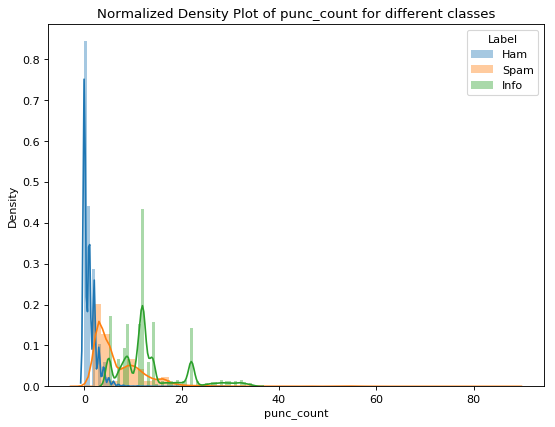

In [ ]:
print("Label distribution of sentences with punctuation count more than 35: ")
print(df[df['punc_count']>35]['Label'].value_counts())

plot_dist_by('punc_count', kde=True)

Interesting! Looks like above a certain punctuation_count limit, all the labels are SPAM. Though, this doesn't make our initial hypothesis (of SPAM = more puncutations) right.
Also visible from the plot with Density estimation.

### Can we distinguish sentences on the basis of occurence of words?
Let us also explore this in original message, cleaned message with punctuations removed, and cleaned message with punctuations and stop words removed.

In [ ]:
def plot_frequency(label='ham', message='Message', num=20):
    count = Counter(" ".join(df[df['Label']==label][message]).split()).most_common(num)
    df1 = pd.DataFrame.from_dict(count)
    df1 = df1.rename(columns={0: f'words in {label}', 1 : "count"})
    df1.plot.bar(legend = False)
    y_pos = np.arange(len(df1[f'words in {label}']))
    plt.xticks(y_pos, df1[f'words in {label}'])
    plt.title(f'Most frequent words in {label} {message}')
    plt.xlabel('words')
    plt.ylabel('number')
    plt.show()

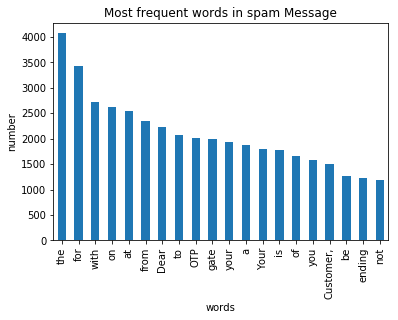

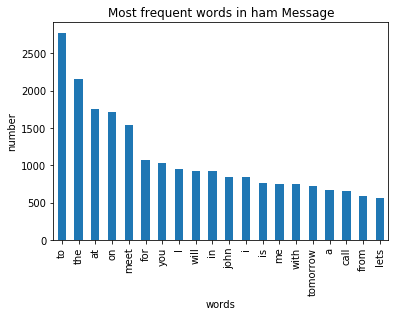

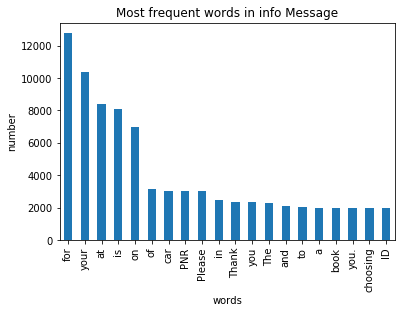

In [ ]:
plot_frequency(label='spam')
plot_frequency(label='ham')
plot_frequency(label='info')

From the above plots, we can observe that the occurence of stop words is high in all classes (which is obvious as these words are most used words in english sentences). Key points to note from above plots:


1.   We can see `Customer,` in most frequent words in SPAM messages. We should remove `,` from the end of all the words for better analysis.
2.   Also, we can see `I` and `i` in HAM messages. Those are the same. We should convert all the messages to lower case. We might lose some information with this like some entities like bank account number is usually writtein in CAPITALS (same with other identity numbers) but we can go ahead with this for further analysis.



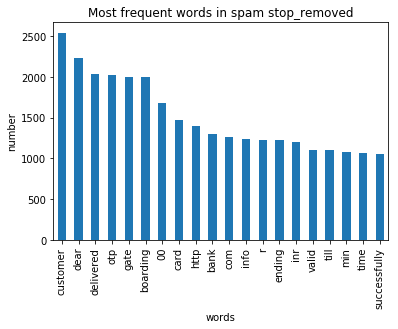

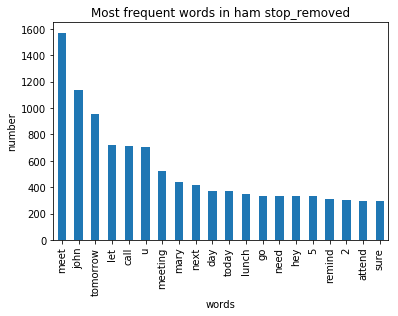

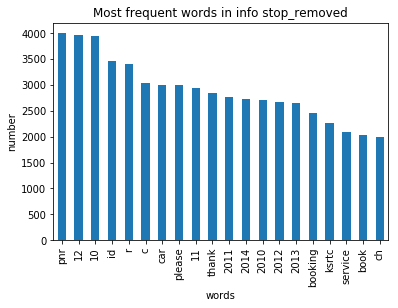

In [ ]:
plot_frequency(label='spam', message='stop_removed')
plot_frequency(label='ham', message='stop_removed')
plot_frequency(label='info', message='stop_removed')

Key points to note from above two plots:


1.   There are certain distinguishing words like `Dear`,  `Customer`, etc. which are clearly occurring quite frequently. Also, both of these words are not stop words. We can definitely explore the usage of word count/frequency in predicting the classes.
2.   We can also see certain words like `Please`, `PNR`, `book`, `choosing` in INFO class. These words are quite often related to Acknowledgement SMS for booking (Hotels/Train/etc.) confirmations.



Seems like by removing punctuations we have got some single character words (in INFO like `r`, `t`, `c`). Let us quickly check how we got there.

In [ ]:
df[df['Label']=='info'].head(100)

,Label,Message,message,punc_count,length,punc_removed,stop_removed
1,info,"Welcome to OVATION HOLD R.No. 184, 114, 395, 3...","welcome to ovation hold r.no. 184, 114, 395, 3...",14,95,welcome to ovation hold r no 184 114 395 378 c...,welcome ovation hold r 184 114 395 378 ch 2014...
2,info,Thank you for using your ICICI bank CREDITcard...,thank you for using your icici bank creditcard...,5,115,thank you for using your icici bank creditcard...,thank using icici bank creditcard ending 5253 ...
9,info,The PNR for your Air India Flt 7I115 for PGH-B...,the pnr for your air india flt 7i115 for pgh-b...,9,151,the pnr for your air india flt 7i115 for pgh b...,pnr air india flt 7i115 pgh bdq 2014 06 25 4 1...
10,info,Bimal Auto Agency : Service of your car KA52C8...,bimal auto agency : service of your car ka52c8...,5,133,bimal auto agency service of your car ka52c837...,bimal auto agency service car ka52c8378 due 72...
11,info,Appointment with Dr Clayton in Pune on 2011-08...,appointment with dr clayton in pune on 2011-08...,7,180,appointment with dr clayton in pune on 2011 08...,appointment dr clayton pune 2011 08 09 12 16 c...
12,info,Maha Veer Auto Agency : Service of your car KA...,maha veer auto agency : service of your car ka...,5,137,maha veer auto agency service of your car ka88...,maha veer auto agency service car ka88n4761 du...
14,info,"Dear Guest, Thanks for choosing Forlini's Rest...","dear guest, thanks for choosing forlini's rest...",13,158,dear guest thanks for choosing forlini s resta...,dear guest thanks choosing forlini restaurant ...
16,info,"Dear Guest, Thanks for choosing 2nd Avenue Del...","dear guest, thanks for choosing 2nd avenue del...",12,152,dear guest thanks for choosing 2nd avenue deli...,dear guest thanks choosing 2nd avenue deli ord...
17,info,Aryan Auto Agency : Service of your car KA87A3...,aryan auto agency : service of your car ka87a3...,5,133,aryan auto agency service of your car ka87a362...,aryan auto agency service car ka87a3626 due 38...
18,info,Welcome to China Shipbuilding Industry R.No. 4...,welcome to china shipbuilding industry r.no. 4...,11,96,welcome to china shipbuilding industry r no 47...,welcome china shipbuilding industry r 475 ch 2...




*   One instance of `r` easily visible is in Row number 18, 240, 251, etc. It came from `R.No.`
*   Also, by observing the HAM messages with sentence length less than 30, we can see that `c` is often used for abbreviating `see`.

To conclude: We will not be able to hand pick all of these edge cases and build a model (even if we do, there can be certain new cases in future data). So, let's build our model on `stop_removed`/`punc_removed`.



## Model Building
Before trying out complex models like RNN, CNN, even simple neural networks, I would like to explore what can Naive Bayes do as we can see correlation with word occurrences only with top 20 words.
Steps:


1.   Comparison between `punc_removed` and `stop_removed` columns for prediciton using Multinomial Naive Bayes Classifier.
2.   On the basis of above comparison, the best column would be used for further analysis/model building. Although, It is not entirely sure that the column that is found to be best from above model is best for other models as well, but this is the best heuristic we can have to save time on building a bit more complex models.



In [ ]:
df["Label"]=df["Label"].map({'spam':0, 'ham':1, 'info': 2})  #Convert Label to integer for prediction

In [ ]:
vectorizer = CountVectorizer()  #Count the number of occurences of each word( from the whole corpus dictionary) in a given sentence.
# No feature scaling required in Naive Bayes
corpus_stop = list(df['stop_removed'].values)
corpus_punc = list(df['punc_removed'].values)
X_stop = vectorizer.fit_transform(corpus_stop)
X_punc = vectorizer.fit_transform(corpus_punc)

In [ ]:
X_stop

<30000x37966 sparse matrix of type '<class 'numpy.int64'>'
	with 433301 stored elements in Compressed Sparse Row format>

### Data Splitting for Train and Test
We use stratified splitting based on frequency of class labels to make sure that the Train and Test set distribution is pretty much the same.

In [ ]:
indices = np.arange(30000)
X_stop_train, X_stop_test, y_stop_train, y_stop_test, idx_stop_train, idx_stop_test = model_selection.train_test_split(X_stop, df['Label'], indices, test_size=0.20, random_state=42, stratify=list(df['Label']))
X_punc_train, X_punc_test, y_punc_train, y_punc_test, idx_punc_train, idx_punc_test = model_selection.train_test_split(X_punc, df['Label'], indices, test_size=0.20, random_state=42, stratify=list(df['Label']))
print([np.shape(X_stop_train), np.shape(X_stop_test)])

[(24000, 37966), (6000, 37966)]


In [ ]:
def train_naive_bayes(X_train, X_test, y_train, y_test):
  list_alpha = np.arange(1/100000, 20, 0.11)
  score_train = np.zeros(len(list_alpha))
  score_test = np.zeros(len(list_alpha))
  recall_test = np.zeros(len(list_alpha))
  precision_test= np.zeros(len(list_alpha))
  f1_test = np.zeros(len(list_alpha))
  f1_train = np.zeros(len(list_alpha))
  count = 0
  for i, alpha in enumerate(list_alpha):
    # class_prior are calculated from class distribution in training set.
    bayes = naive_bayes.MultinomialNB(alpha=alpha, class_prior=[0.22083333333, 0.333333333, 0.445833333])
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test), average='weighted')
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test), average='weighted')
    f1_test[count] = f1_score(y_test, bayes.predict(X_test), average='weighted')
    f1_train[count] = f1_score(y_train, bayes.predict(X_train), average='weighted')
    count = count + 1 
  return list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test

In [ ]:
# Model on stop_words removed sentences
list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_naive_bayes(X_stop_train, X_stop_test, y_stop_train, y_stop_test)
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_stop = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
print("Stop words removed Model")
print(models_stop.head(n=10))

# Model on punctuations removed sentences
list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_naive_bayes(X_punc_train, X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
print("Punctuations removed Model")
print(models_punc.head(n=10))


Stop words removed Model
     alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
0  0.00001        0.997167       0.988500     0.988500        0.988621   
1  0.11001        0.994792       0.990167     0.990167        0.990152   
2  0.22001        0.994125       0.989167     0.989167        0.989146   
3  0.33001        0.993500       0.988167     0.988167        0.988148   
4  0.44001        0.993000       0.988167     0.988167        0.988152   
5  0.55001        0.992667       0.988167     0.988167        0.988149   
6  0.66001        0.992083       0.987167     0.987167        0.987149   
7  0.77001        0.991500       0.986667     0.986667        0.986655   
8  0.88001        0.991083       0.986833     0.986833        0.986830   
9  0.99001        0.990708       0.987167     0.987167        0.987165   

   Train F1 Score  Test F1 Score  
0        0.997164       0.988496  
1        0.994785       0.990155  
2        0.994118       0.989154  
3        0.993492   

Let us select the best model out of these on the basis of `Test F1 Score`, `Test Precision` and then `Train F1 Score`

In [ ]:
print("Best stop words removed model Test F1 Scirem Test Precision and Train F1 Score Accuracy")
print(models_stop.sort_values(['Test F1 Score', 'Train F1 Score'], ascending=[False, False]).head(1))
print("Best punctuations removed model Test F1 Scirem Test Precision and Train F1 Score Accuracy")
print(models_punc.sort_values(['Test F1 Score', 'Train F1 Score'], ascending=[False, False]).head(1))

Best stop words removed model Test F1 Scirem Test Precision and Train F1 Score Accuracy
     alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
1  0.11001        0.994792       0.990167     0.990167        0.990152   

   Train F1 Score  Test F1 Score  
1        0.994785       0.990155  
Best punctuations removed model Test F1 Scirem Test Precision and Train F1 Score Accuracy
     alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
1  0.11001        0.996667       0.992167     0.992167        0.992155   

   Train F1 Score  Test F1 Score  
1        0.996665       0.992159  


Looks like we should use `punc_removed` and not `stop_removed` for our model building. For further analysis, we will only use `punc_removed`.

*   List item
*   List item



Let us make Confusion Matrix of our best model and analyze the results further.

In [ ]:
from sklearn.metrics import confusion_matrix
bayes = naive_bayes.MultinomialNB(alpha=0.11010)
bayes.fit(X_punc_train, y_punc_train)
y_pred_test = bayes.predict(X_punc_test)
y_pred_train = bayes.predict(X_punc_train)
print(confusion_matrix(y_punc_test, y_pred_test))


[[1304   21    0]
 [  18 1974    8]
 [   0    0 2675]]


Let us look at the wrongly predicted rows

In [ ]:
def find_rows_with(y_true, y_pred, idx, true_label_in, predicted_label_in):
  '''
  Inputs: y_true, y_pred, idx (for finding rows and printing original SMS), true_label_in (list), predicted_label_in (list) and data (type)
  Output: Returns id of the rows (from original dataframe)
  '''
  l = []
  for i,j in enumerate(y_true):
    if j in true_label_in and y_pred[i] in predicted_label_in:
        l.append(idx[i])
  return l
  

In [ ]:
# Rows which are class 0 but predicted 1 (i.e. SPAM but predicted HAM)
row_ids = find_rows_with(y_punc_test, y_pred_test, idx_punc_test, [0], [1])
      
for i in row_ids:
  print(list(df.iloc[i]))
  print(f"Length: {df.iloc[i]['length']}")
  print(f"punc_count: {df.iloc[i]['punc_count']}")

[0, 'As there is change in RTO Website migration from sarati 3 to sarathi 4 fr online submission, u have to give all relevent documet to upload along with ur photo & signature as their some document missing plz contact drivng school Regards MVMDSchool', 'as there is change in rto website migration from sarati 3 to sarathi 4 fr online submission, u have to give all relevent documet to upload along with ur photo & signature as their some document missing plz contact drivng school regards mvmdschool', 2, 246, 'a there is change in rto website migration from sarati 3 to sarathi 4 fr online submission u have to give all relevent documet to upload along with ur photo signature a their some document missing plz contact drivng school regard mvmdschool', 'change rto website migration sarati 3 sarathi 4 fr online submission u give relevent documet upload along ur photo signature document missing plz contact drivng school regard mvmdschool']
Length: 246
punc_count: 2
[0, 'Now make a friend which 

We observe that length can be further used to improve above results (length>=400 is always a SPAM) -- **(A)**

In [ ]:
# Rows which are class 1 but predicted otherwise (i.e. HAM but predicted otherwise)

row_ids = find_rows_with(y_punc_train, y_pred_train, idx_punc_train, [1], [0, 2])
length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
print(f"Total number of rows in train set classified otherwise but actually HAM are {len(length)}")
print(f"Total number of rows in train set with sentence length less than or equal to 30 are {len([i for i in length if i<=30])}")

Total number of rows in train set classified otherwise but actually HAM are 59
Total number of rows in train set with sentence length less than or equal to 30 are 35


In [ ]:
# Rows which are class 1 but predicted otherwise (i.e. HAM but predicted otherwise)
row_ids = find_rows_with(y_punc_test, y_pred_test, idx_punc_test, [1], [0, 2])
length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
print(f"Total number of rows in test set classified otherwise but actually HAM are {len(length)}")
print(f"Total number of rows in test set with sentence length less than or equal to 30 are {len([i for i in length if i<=30])}")

Total number of rows in test set classified otherwise but actually HAM are 26
Total number of rows in test set with sentence length less than or equal to 30 are 16


*We can apply a condition here from the observation we had in EDA that all the SMS with class HAM have a character length of less than 30 (4124 observations in total dataset) which is around 14% of overall data. We can confidentally predict these as HAM instead of other class.*   -- **(A)**

By applying this logic, we can improve 16/26 predictions in test and 35/59 predictions in train set.

Quite good results for such a simple algorithm. Let us also explore `TfidfVectorizer` instead of `CountVectorizer`.

In [ ]:
vectorizer = TfidfVectorizer()
corpus_punc = list(df['punc_removed'].values)
X_punc = vectorizer.fit_transform(corpus_punc)

In [ ]:
indices = np.arange(30000)
length = df['length']
# Length and indices are required for analysis later.
X_punc_train, X_punc_test, y_punc_train, y_punc_test, idx_punc_train, idx_punc_test, length_train, length_test = model_selection.train_test_split(X_punc, df['Label'], indices, length, test_size=0.20, random_state=42, stratify=list(df['Label']))

In [ ]:
# Model on punctuations removed sentences
list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_naive_bayes(X_punc_train, X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
print("Punctuations removed Model with Tfidf Vectorizer")
print(models_punc.head(n=10))


Punctuations removed Model with Tfidf Vectorizer
     alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
0  0.00001        0.998708       0.989333     0.989333        0.989439   
1  0.11001        0.997250       0.992333     0.992333        0.992331   
2  0.22001        0.996250       0.991333     0.991333        0.991337   
3  0.33001        0.995125       0.991000     0.991000        0.991010   
4  0.44001        0.994417       0.990500     0.990500        0.990520   
5  0.55001        0.993875       0.989667     0.989667        0.989689   
6  0.66001        0.993250       0.989500     0.989500        0.989514   
7  0.77001        0.992417       0.988833     0.988833        0.988850   
8  0.88001        0.991625       0.988000     0.988000        0.988014   
9  0.99001        0.990958       0.987667     0.987667        0.987689   

   Train F1 Score  Test F1 Score  
0        0.998708       0.989333  
1        0.997249       0.992323  
2        0.996247       0.99132

`TfidfVectorizer` is slightly better than `CountVectorizer`. For further analysis/model building, we will use `TfidfVectorizer`.

In [ ]:
print("Best punctuations removed model Test F1 Score, Test Precision and Train F1 Score")
print(models_punc.sort_values(['Test F1 Score', 'Test Precision', 'Train F1 Score'], ascending=[False, False, False]).head(1))

Best punctuations removed model Test Precision and Test Accuracy
     alpha  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
1  0.11001         0.99725       0.992333     0.992333        0.992331   

   Train F1 Score  Test F1 Score  
1        0.997249       0.992323  


In [ ]:
from sklearn.metrics import confusion_matrix
bayes = naive_bayes.MultinomialNB(alpha=0.11010)
bayes.fit(X_punc_train, y_punc_train)
y_pred_test = bayes.predict(X_punc_test)
y_pred_train = bayes.predict(X_punc_train)
print(confusion_matrix(y_punc_test, y_pred_test))

[[1298   27    0]
 [  12 1981    7]
 [   0    0 2675]]


\#TODO: With Simple Multinomial Bayes classifier and hyperparameter tuning, we are able to have a high F1 score of 0.992323 on test set. Let us now add our logic (A) and improve our model accuracy.
Not required for now as SVM Model brings down the number (18+8) to (3+1). Therefore, we can skip this for now.

## SVM Model

In [ ]:
# Normalize the features to bring values between range 0 and 1.
# I found Normalization (row-wise) to be more helpful than StandardSclaer in this particular case.
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(X_punc_train)

X_punc_train = transformer.transform(X_punc_train)
X_punc_test = transformer.transform(X_punc_test)

In [ ]:
X_punc_train.shape

(24000, 38086)

In [ ]:
# We will have to reduce the feature dimensions as we only have 24k rows for training while the number of columns are around 38k which
# is a sparse matrix and will not be able to learn.
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
svd = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)
svd.fit(X_punc_train)  

 
print(f"Total Variance explained by 2k features is {svd.explained_variance_ratio_.sum()}")  

 
new_X_punc_train, new_X_punc_test = svd.transform(X_punc_train), svd.transform(X_punc_test)

Total Variance explained by 2k features is 0.76509202718298


In [ ]:
def train_svm(X_train, X_test, y_train, y_test):
  list_C = np.arange(1000, 30000, 1000)
  score_train = np.zeros(len(list_C))
  score_test = np.zeros(len(list_C))
  recall_test = np.zeros(len(list_C))
  precision_test= np.zeros(len(list_C))
  f1_test= np.zeros(len(list_C))
  f1_train= np.zeros(len(list_C))
  count = 0
  for C in list_C:
      svc = svm.SVC(C=C, class_weight='balanced')
      svc.fit(X_train, y_train)
      score_train[count] = svc.score(X_train, y_train)
      score_test[count]= svc.score(X_test, y_test)
      recall_test[count] = metrics.recall_score(y_test, svc.predict(X_test), average='weighted')
      precision_test[count] = metrics.precision_score(y_test, svc.predict(X_test), average='weighted')
      f1_test[count] = f1_score(y_test, svc.predict(X_test), average='weighted')
      f1_train[count] = f1_score(y_train, svc.predict(X_train), average='weighted')
      count = count + 1
      print(f"C = {C} done")
  return list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test

F1 score on Train set: 0.9966647101960555
F1 score on Test set: 0.9921590766869874


In [ ]:
# SVM Model on punctuations removed sentences with TFIDF Vectorizer
list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_svm(X_punc_train, X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
models_punc.head(n=10)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C = 1000 done
C = 2000 done
C = 3000 done
C = 4000 done
C = 5000 done
C = 6000 done
C = 7000 done
C = 8000 done
C = 9000 done
C = 10000 done
C = 11000 done
C = 12000 done
C = 13000 done
C = 14000 done
C = 15000 done
C = 16000 done
C = 17000 done
C = 18000 done
C = 19000 done
C = 20000 done
C = 21000 done
C = 22000 done
C = 23000 done
C = 24000 done
C = 25000 done
C = 26000 done
C = 27000 done
C = 28000 done
C = 29000 done


,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Train F1 Score,Test F1 Score
0,1000.0,0.989333,0.989333,0.989333,0.989574,0.989293,0.989289
1,2000.0,0.994083,0.992167,0.992167,0.992277,0.994073,0.992144
2,3000.0,0.995583,0.993833,0.993833,0.993897,0.995578,0.993821
3,4000.0,0.996708,0.994167,0.994167,0.994212,0.996706,0.994157
4,5000.0,0.997667,0.995167,0.995167,0.995199,0.997666,0.995160
5,6000.0,0.998167,0.995500,0.995500,0.995526,0.998166,0.995494
6,7000.0,0.998375,0.996167,0.996167,0.996183,0.998375,0.996163
7,8000.0,0.998667,0.996500,0.996500,0.996517,0.998667,0.996497
8,9000.0,0.998792,0.996500,0.996500,0.996512,0.998792,0.996497
9,10000.0,0.999083,0.997000,0.997000,0.997007,0.999083,0.996998


In [ ]:
print("Best punctuations removed model (TfidfVectorizer) Test F1 Score, Test Precision and Train F1 Score")
print(models_punc.sort_values(['Test F1 Score', 'Test Precision', 'Train F1 Score'], ascending=[False, False, False]).head(1))

Best punctuations removed model (TfidfVectorizer) Test F1 Score, Test Precision and Train F1 Score
          C  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
16  17000.0        0.999542          0.998        0.998        0.998002   

    Train F1 Score  Test F1 Score  
16        0.999542       0.997999  


In [ ]:
from sklearn.metrics import confusion_matrix
svc = svm.SVC(C=17000, class_weight='balanced')
svc.fit(new_X_punc_train, y_punc_train)
y_pred_test = svc.predict(new_X_punc_test)
y_pred_train = svc.predict(new_X_punc_train)
print(confusion_matrix(y_punc_test, y_pred_test))
print(f"F1 score on Train set: {f1_score(y_punc_train, y_pred_train, average='weighted')}")
print(f"F1 score on Test set: {f1_score(y_punc_test, y_pred_test, average='weighted')}")


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[1310   15    0]
 [  15 1985    0]
 [   0    0 2675]]
F1 score on Train set: 0.999875001989176
F1 score on Test set: 0.995


In [ ]:
# Actually SPAM but predicted HAM
row_ids = find_rows_with(y_punc_test, y_pred_test, idx_punc_test, [0], [1])
length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
      
for i in row_ids:
  print(list(df.iloc[i]))

[0, 'Grofers Housefull Sale, 1-3 every month Lowest prices & biggest savings Additional cashback up to Rs.150 Code HF150 Prices lower than supermarkets. Every day!', 'grofers housefull sale, 1-3 every month lowest prices & biggest savings additional cashback up to rs.150 code hf150 prices lower than supermarkets. every day!', 6, 158, 'grofers housefull sale 1 3 every month lowest price biggest saving additional cashback up to r 150 code hf150 price lower than supermarket every day', 'grofers housefull sale 1 3 every month lowest price biggest saving additional cashback r 150 code hf150 price lower supermarket every day']
[0, 'Transfer balance from other credit cards to SBI Card & continue enjoying interest free period upto50days on retail trxn. Repay in EMIs.Call 18761585218.T&C', 'transfer balance from other credit cards to sbi card & continue enjoying interest free period upto50days on retail trxn. repay in emis.call 18761585218.t&c', 5, 155, 'transfer balance from other credit card 

In [ ]:
# Rows which are class 1 but predicted otherwise on Test set (i.e. HAM but predicted otherwise)
row_ids = find_rows_with(y_punc_test, y_pred_test, idx_punc_test, [1], [0, 2])
length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
print(f"Total number of rows in test set classified otherwise but actually HAM are {len(length)}")
print(f"Total number of rows in test set with sentence length less than or equal to 30 are {len([i for i in length if i<=30])}")

Total number of rows in test set classified otherwise but actually HAM are 15
Total number of rows in test set with sentence length less than or equal to 30 are 7


In [ ]:
# Rows which are class 1 but predicted otherwise on Training set (i.e. HAM but predicted otherwise)
row_ids = find_rows_with(y_punc_train, y_pred_train, idx_punc_train, [1], [0, 2])
length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
print(f"Total number of rows in test set classified otherwise but actually HAM are {len(length)}")
print(f"Total number of rows in test set with sentence length less than or equal to 30 are {len([i for i in length if i<=30])}")

Total number of rows in test set classified otherwise but actually HAM are 2
Total number of rows in test set with sentence length less than or equal to 30 are 1


In [ ]:
print("Confusion matrix for train set")
print(confusion_matrix(y_punc_train, y_pred_train))
print("Confusion matrix for test set")
print(confusion_matrix(y_punc_test, y_pred_test))

Confusion matrix for train set
[[ 5299     1     0]
 [    2  7998     0]
 [    0     0 10700]]
Confusion matrix for test set
[[1310   15    0]
 [  15 1985    0]
 [   0    0 2675]]


We can see overfitting here as the predictions on train set are almost perfect. One thing we can do is apply (A) which we talked about previously.

In [ ]:
def predict(X, length):
  y_pred = svc.predict(X)
  for i in range(len(length)):
    if length[i]<=30:
      y_pred[i] = 1
    elif length[i]>=400:
      y_pred[i] = 0
  return y_pred
y_pred_test = predict(new_X_punc_test, list(length_test))
print(confusion_matrix(y_punc_test, y_pred_test))

[[1310   15    0]
 [   8 1992    0]
 [   0    0 2675]]


In [ ]:
print(f"F1 score on Test set: {f1_score(y_punc_test, y_pred_test, average='weighted')}")

F1 score on Test set: 0.9961649386716139


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
def train_logistic(X_train, X_test, y_train, y_test):
  list_C = np.arange(5, 11, 1) #100000
  score_train = np.zeros(len(list_C))
  score_test = np.zeros(len(list_C))
  recall_test = np.zeros(len(list_C))
  precision_test= np.zeros(len(list_C))
  f1_test = np.zeros(len(list_C))
  f1_train = np.zeros(len(list_C))
  count = 0
  for C in list_C:
      clf = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, C=C, class_weight='balanced', multi_class='multinomial').fit(X_train, y_train)
      score_train[count] = clf.score(X_train, y_train)
      score_test[count]= clf.score(X_test, y_test)
      recall_test[count] = metrics.recall_score(y_test, clf.predict(X_test), average='weighted')
      precision_test[count] = metrics.precision_score(y_test, clf.predict(X_test), average='weighted')
      f1_test[count] = f1_score(y_test, clf.predict(X_test), average='weighted')
      f1_train[count] = f1_score(y_train, clf.predict(X_train), average='weighted')
      count = count + 1
      print(f"C = {C} done")
  return list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test
  

In [ ]:
list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_logistic(new_X_punc_train, new_X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc_log = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
models_punc_log.head(n=10)

C = 5 done
C = 6 done
C = 7 done
C = 8 done
C = 9 done
C = 10 done


,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Train F1 Score,Test F1 Score
0,5.0,0.998708,0.995667,0.995667,0.995671,0.998708,0.995664
1,6.0,0.998792,0.995667,0.995667,0.995671,0.998791,0.995664
2,7.0,0.999000,0.995833,0.995833,0.995837,0.999000,0.995831
3,8.0,0.999042,0.995833,0.995833,0.995835,0.999042,0.995831
4,9.0,0.999208,0.995833,0.995833,0.995835,0.999208,0.995831
5,10.0,0.999292,0.995833,0.995833,0.995835,0.999292,0.995831


In [ ]:
list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_logistic(new_X_punc_train, new_X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc_log = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
models_punc_log.head(n=10)

C = 1 done
C = 2 done
C = 3 done
C = 4 done


,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Train F1 Score,Test F1 Score
0,1.0,0.996583,0.994167,0.994167,0.994179,0.996581,0.994160
1,2.0,0.997667,0.994667,0.994667,0.994674,0.997666,0.994662
2,3.0,0.998292,0.995000,0.995000,0.995008,0.998291,0.994996
3,4.0,0.998458,0.995000,0.995000,0.995008,0.998458,0.994996


In [ ]:
list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test = train_logistic(new_X_punc_train, new_X_punc_test, y_punc_train, y_punc_test)
matrix = np.matrix(np.c_[list_C, score_train, score_test, recall_test, precision_test, f1_train, f1_test])
models_punc_log = pd.DataFrame(data = matrix, columns = 
             ['C', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision', 'Train F1 Score', 'Test F1 Score'])
models_punc_log.head(n=10)

(24000, 2000)
(6000, 2000)
C = 0.1 done
C = 0.2 done
C = 0.30000000000000004 done
C = 0.4 done
C = 0.5 done
C = 0.6 done
C = 0.7000000000000001 done
C = 0.8 done
C = 0.9 done


,C,Train Accuracy,Test Accuracy,Test Recall,Test Precision,Train F1 Score,Test F1 Score
0,0.1,0.989250,0.989333,0.989333,0.989475,0.989210,0.989295
1,0.2,0.992625,0.991333,0.991333,0.991417,0.992609,0.991308
2,0.3,0.994083,0.991833,0.991833,0.991897,0.994075,0.991814
3,0.4,0.995000,0.992333,0.992333,0.992374,0.994994,0.992318
4,0.5,0.995375,0.993500,0.993500,0.993530,0.995370,0.993490
5,0.6,0.995583,0.993833,0.993833,0.993851,0.995579,0.993826
6,0.7,0.996042,0.994167,0.994167,0.994179,0.996038,0.994160
7,0.8,0.996167,0.994167,0.994167,0.994179,0.996164,0.994160
8,0.9,0.996458,0.994167,0.994167,0.994179,0.996456,0.994160


In [ ]:
print("Best punctuations removed model (TfidfVectorizer) Test F1 Score, Test Precision and Train F1 Score")
print(models_punc_log.sort_values(['Test F1 Score', 'Test Precision', 'Train F1 Score'], ascending=[False, False, False]).head(1))

Best punctuations removed model (TfidfVectorizer) Test F1 Score, Test Precision and Train F1 Score
      C  Train Accuracy  Test Accuracy  Test Recall  Test Precision  \
5  10.0        0.999292       0.995833     0.995833        0.995835   

   Train F1 Score  Test F1 Score  
5        0.999292       0.995831  


In [ ]:
from sklearn.metrics import confusion_matrix
clf = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced',  max_iter=1000, C=10, multi_class='multinomial').fit(new_X_punc_train, y_punc_train)
y_pred_test = clf.predict(new_X_punc_test)
y_pred_train = clf.predict(new_X_punc_train)
print(confusion_matrix(y_punc_test, y_pred_test))
print(confusion_matrix(y_punc_train, y_pred_train))

[[1309   16    0]
 [   9 1991    0]
 [   0    0 2675]]
[[ 5292     8     0]
 [    9  7991     0]
 [    0     0 10700]]


In [ ]:
y_pred_test = predict(new_X_punc_test, list(length_test))

In [ ]:
# Rows which are class 1 but predicted otherwise (i.e. HAM but predicted otherwise)
row_ids = find_rows_with(y_punc_train, y_pred_train, idx_punc_train, [1], [0, 2])

length = []
for i in row_ids:
  length.append(df.iloc[i]['length'])
print(f"Total number of rows in test set classified otherwise but actually HAM are {len(length)}")
print(f"Total number of rows in test set with sentence length less than or equal to 30 are {len([i for i in length if i<=30])}")

Total number of rows in test set classified otherwise but actually HAM are 9
Total number of rows in test set with sentence length less than or equal to 30 are 1


In [ ]:
y_pred_test = predict(new_X_punc_test, list(length_test))
print(confusion_matrix(y_punc_test, y_pred_test))

[[1310   15    0]
 [   8 1992    0]
 [   0    0 2675]]


In [ ]:
print(f"F1 score on Test set: {f1_score(y_punc_test, y_pred_test, average='weighted')}")

F1 score on Test set: 0.9961649386716139


Seems like Logistic regression has less variance and almost same bias compared to SVM.

Let us directly stack length column to our training set and feed it to logistic regression model and test it for C=10.

In [ ]:
new_X_punc_stacked_train = np.column_stack((new_X_punc_train,length_train))
new_X_punc_stacked_test = np.column_stack((new_X_punc_test,length_test))

In [ ]:
from sklearn.metrics import confusion_matrix
clf = LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced', max_iter=5000, C=10, multi_class='multinomial').fit(new_X_punc_stacked_train, y_punc_train)
y_pred_test = clf.predict(new_X_punc_stacked_test)
y_pred_train = clf.predict(new_X_punc_stacked_train)
print(confusion_matrix(y_punc_test, y_pred_test))
print(confusion_matrix(y_punc_train, y_pred_train))

[[1315   10    0]
 [   6 1994    0]
 [   0    0 2675]]
[[ 5297     3     0]
 [   11  7989     0]
 [    0     0 10700]]


In [ ]:
print(f"F1 score on Test set: {f1_score(y_punc_test, y_pred_test, average='weighted')}")
print(f"F1 score on Train set: {f1_score(y_punc_train, y_pred_train, average='weighted')}")

F1 score on Test set: 0.997332649713602
F1 score on Train set: 0.999416740720159


This clearly increased the performance of our model

# Conclusion



*   We can try word2vec (or other) embeddings, stack them and try applying logistic regression, feedforward neural network, RNN but I was motivated to follow the above approach due to the simplicity of above algorithms, the **Brownie Point** as well as because there are many abbreviations used in SMS which are not common in English Language. The way to work around that is to train a word embedding model on our dataset and then utilize those word embedding for our task.
*   I also tried Random Forest (without hyperparameter tuning) and that was also giving similar results as Naive Bayes.
*   **Future Work**: 

      1.   We can combine multiple different kinds of models to create an ensemble model.
      2.   `punc_count` can also be merged with the features.
      3.   Also, I noticed some long URLs in SPAM which could be explored to increase performance.
      
*   **Mistakes noted**:

      1. Length should be normalized and then stacked to the matrix for logistic regression.
      2. `punc_count` should not be used directly. Instead `punc_count/length` would be a better feature as it is normalized.
      



